<a href="https://colab.research.google.com/github/100495773/Grupo05_Practica2/blob/main/notebook_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#PRACTICA 2 APRENDIZAJE AUTOMATICO
#(Fernando Mendizabal - 100495773)
En esta práctica aprenderemos a aplicar técnicas de aprendizaje no supervisado sobre un conjunto de datos con atributos sobre semilla. En concreto, se trabajará con métodos de agrupamiento/clustering.

Insertamos el fichero correspondiente.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving semillas.csv to semillas.csv


A continuación, hacemos los debidos imports.

In [3]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================
from sklearn.cluster import KMeans
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

A continuación se cargará el fichero del dataset en un dataframe manipulable en Python.

In [4]:
df = pd.read_csv('semillas.csv')

#EDA (Exploratory Data Analysis)

Lo primero que realizaremos en esta práctica será la creación de un pequeño EDA, con el fin de entender los datos con los que estamos trabajando.

In [ ]:
df.head()

area  perimetro  compacidad  longitud  anchura  asimetria  surco  clase
0  15.26      14.84      0.8710     5.763    3.312      2.221  5.220      1
1  14.88      14.57      0.8811     5.554    3.333      1.018  4.956      1
2  14.29      14.09      0.9050     5.291    3.337      2.699  4.825      1
3  13.84      13.94      0.8955     5.324    3.379      2.259  4.805      1
4  16.14      14.99      0.9034     5.658    3.562      1.355  5.175      1

In [ ]:
print('Shape of Data Table (Instances, Attributes):')
print('===============================')
print(df.shape)
print()

print('Types of Attributes:')
print('================================')
df.info()

print()

print('Missing Values per Attribute:')
print('======================================')
print(df.isnull().sum())

print()

print('Unique Values per Attribute:')
print('======================================')
print(df.nunique())


Shape of Data Table (Instances, Attributes):
(210, 8)

Types of Attributes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 210 entries, 0 to 209
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   area        210 non-null    float64
 1   perimetro   210 non-null    float64
 2   compacidad  210 non-null    float64
 3   longitud    210 non-null    float64
 4   anchura     210 non-null    float64
 5   asimetria   210 non-null    float64
 6   surco       210 non-null    float64
 7   clase       210 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 13.3 KB

Missing Values per Attribute:
area          0
perimetro     0
compacidad    0
longitud      0
anchura       0
asimetria     0
surco         0
clase         0
dtype: int64

Unique Values per Attribute:
area          193
perimetro     170
compacidad    186
longitud      188
anchura       184
asimetria     207
surco         148
clase           3
dtype: int64


Por lo que podemos observar en los datos, hay 210 instancias con 8 variables. No existen datos nulos. Además, todas las variables son de tipo numérico. Podemos ver claramente que la variable objetivo del conjunto de los datos es "clase", haciendo referencia al número de conjuntos en los que se separan las diferentes instancias del total del dataset.

#Comparación Scalers


A continuación, vamos a seleccionar el mejor método de preprocesado a emplear para tratar los datos a introducir en los clusters. Para que los datos puedan ser interpretados por los diferentes métodos de clustering, emplearemos un escalado de datos por preprocesamiento. Para comprobar cual de los escalados es el idóneo a emplear en nuesstro conjunto de datos, observaremos visualmente el comportamiento de los tres Scalers más destacables: MinMaxScaler, StandardScaler y RobustScaler. Para su representación gráfica, en su preprocesado añadiremos un PCA con 2 componentes, para poder representar en 2 dimensiones la distribución de los datos. Además, se diferenciarán las instancias del conjunto de datos en base a su valor en la variable objetivo "clase". Con ello, podremos llegar a la conclusión de qué escalador da como resultado un mejor agrupamiento de los datos.

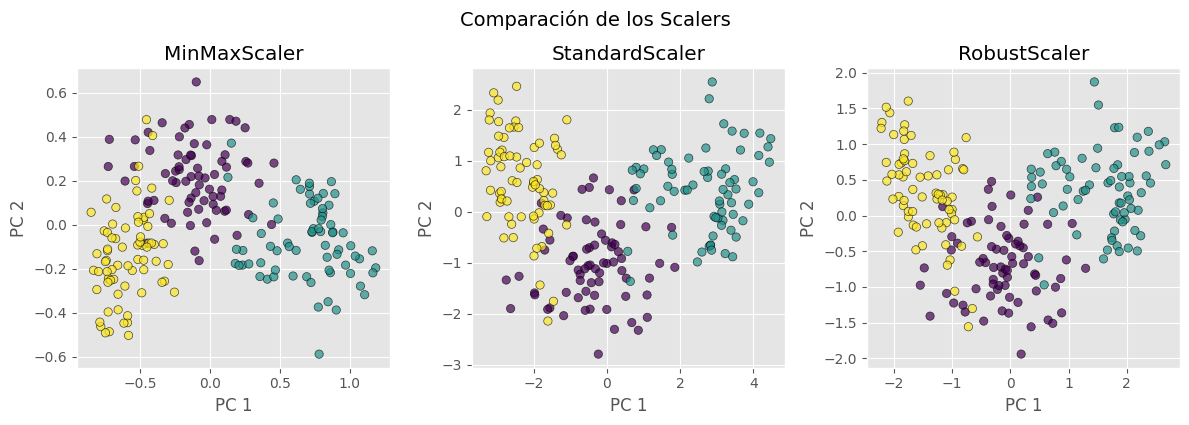

In [ ]:
X = df.drop(columns=['clase'])
y = df['clase']

scalers = [MinMaxScaler(), StandardScaler(), RobustScaler()]

plt.figure(figsize=(12, 4))

for i, scaler in enumerate(scalers, 1):
    pipe = Pipeline([
        ('scaler', scaler),
        ('pca', PCA(n_components=2))
    ])

    X_pca = pipe.fit_transform(X)

    plt.subplot(1, 3, i)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', edgecolor='k', alpha=0.7)
    plt.title(type(scaler).__name__)
    plt.xlabel('PC 1')
    plt.ylabel('PC 2')

plt.tight_layout()
plt.suptitle('Comparación de los Scalers', fontsize=14, y=1.05)
plt.show()

Como podemos observar en la gráfica anterior, el comportamiento de los tres Scalers es muy similar. Con ello podemos concluir que la elección de un escalado específico no es determinante en el correcto desempeño de los métodos de clustering que vamos a estudiar. Debido a esto se ha decidido emplear el tipo de escalado más general o estandar, en nuestro caso el StandardScaler(). Este se empleará en los casos debidos.

#Métodos Clustering

Ahora emplearemos los diferentes métodos de clustering aprendidos en el curso sobre nuestros datos, para compararlos entre sí y averiguar cuál de ellos es el más idóneo para nuestro problema: KMeans, Hierarchical Clustering/Dendrogramas y DBSCAN. Para cada uno de los diferentes métodos, en sus respectivos casos, se buscarán sus mejores hiperparámetros. Ya que al ser un problema no supervisado, sacaremos la variable 'clase' del conjunto de datos a manipular, y será usada únicamente para la representación gráfica de los diferentes métodos.

In [5]:
X = df.drop(columns=['clase'])
y = df['clase']

Empezaremos probando nuestro conjunto de datos en el método KMeans. Este método consiste en la división del conjunto de datos en base a un número fijo de agrupaciones dado. Comienza con la generación aleatoria de puntos de referencia, tantos como clusters especificados, que se colocarán en el conjunto de datos. Las instancias de nuestros datos se agruparán con su punto de referencia más cercano, y dicho punto se reajustará para acercarse más al grueso de un agrupamiento de datos. Esta operación será repetida tantas veces como las iteraciones especificadas en los hiperparámetros.

El preprocesamiento de los datos para su correcta visualización e interpretación se realizará con el escalador escogido y el PCA debido.

In [6]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

X_scaled = pipe.fit_transform(X)

Vamos a realizar el caso por omisión del modelo KMeans. Especificamos "n_clusters" como 3, ya que son los grupos que sabemos que posee el conjunto de datos, información obtenida en el EDA. La reproducibilidad de los datos será garantizada al colocar nuestro NIA por "ramdon_state".

In [7]:
modelo_kmeans = KMeans(n_clusters=3, n_init=25, random_state=100495773)
modelo_kmeans.fit(X=X_scaled)

KMeans(n_clusters=3, n_init=25, random_state=100495773)

In [8]:
y_predict = modelo_kmeans.predict(X=X_scaled)

Imprimimos por pantalla la separación de grupos generada por nuestro modelo KMeans. Se indica cada uno de estos grupos con un diferente color, y se ven representados sus centroides, que servirían como puntos de refreencia de estos grupos.

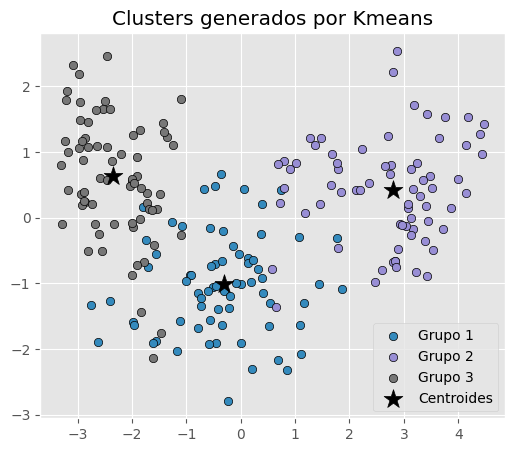

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
for i in np.unique(y):
    ax.scatter(
        x = X_scaled[y == i, 0],
        y = X_scaled[y == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Grupo {i}"
    )

ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'Centroides'
)
ax.set_title('Clusters generados por Kmeans')
ax.legend();

Como podemos observar, el modelo ha hecho un buen trabajo representando la division del conjunto de los datos en los diferentes grupos. Sin embargo, podemos observar que hay ciertas instancias alejadas del gruseo del grupo al que pertenecen. Esto provoca que en algunos casos los grupos geneardos por el Kmeans sean heterogeneos cuando deberían ser homogeneos en su totalidad, o al menos ese es el resultado óptimo que esperamos alcanzar.

Ahora realizaremos la búsqueda de sus mejores hiperparámetros. Para la realización de esta búsqueda nos centraremos en el número de clusters. Emplearemos tanto el método Elbow como el método Silhouette para encontrar el valor idóneo.

Vamos a imprimir de forma gráfica la evolución del método Elbow para cada instancia de este hiperparámetro.

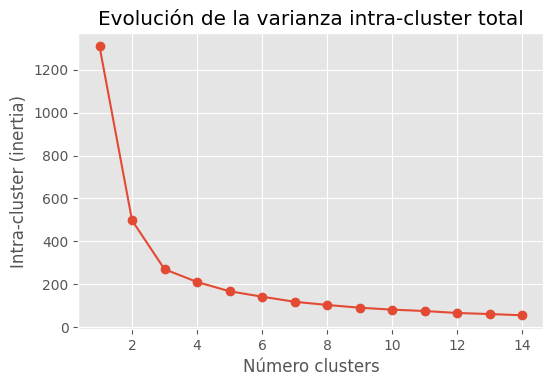

In [10]:
range_n_clusters = range(1, 15)
inertias = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    modelo_kmeans.fit(X_scaled)
    inertias.append(modelo_kmeans.inertia_)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, inertias, marker='o')
ax.set_title("Evolución de la varianza intra-cluster total")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Intra-cluster (inertia)');

Posteriormente, imprimiremos la evolución del método Silhouette.

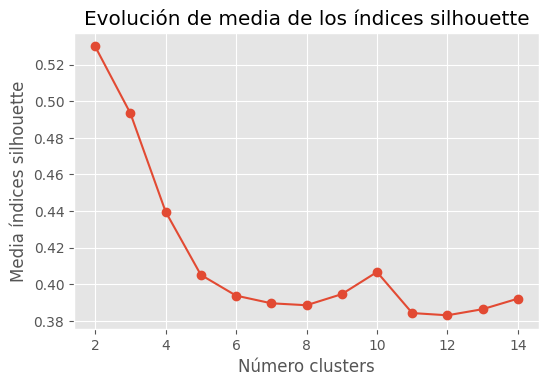

In [11]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans(
        n_clusters   = n_clusters,
        n_init       = 20,
        random_state = 42
    )
    cluster_labels = modelo_kmeans.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Para la obtención del valor en el método Elbow nos debemos fijar en el codo de la gráfica, el punto en el que su decrecimiento se ve reducido de forma abrupta. En cuanto al método Silhouette, nos debemos fijar en el valor más alto obtenido en la media de los índices. La conclusión obtenida por el método Elbow es "3" como valor idóneo, y por el método Silhouette es "2". Dado que "3" es un valor que también es bastante importante en el método Silhouette, escogeremos este para el modelo final KMeans.

In [12]:
modelo_kmeans = KMeans(n_clusters=3, n_init=25, random_state=100495773)
modelo_kmeans.fit(X=X_scaled)

y_predict_kmeans = modelo_kmeans.predict(X=X_scaled)

Ahora realizaremos la prueba con el método Jerárquico o de Dendogramas. Este método consiste en la generación de una estructura de árbol en la que se ven representadas las agrupaciones de las instancias según diferentes niveles de similitud en sus variables. La variante de este método que emplearemos es la Agglomerative o bottom-up. Este comienza con la separación de las instancias del dataset en clusters individuales, para posteriormente encontrar similitudes entre estas sobre las que definir una agrupación. Este método emplea como variables de entrada en forma de Dataframe, por lo que deberemos introducir nuestros datos escalados en este formato.

In [13]:
X_scaled = scale(X=X, axis=0, with_mean=True, with_std=True)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
X_scaled.head()

area  perimetro  compacidad  longitud   anchura  asimetria     surco
0  0.142098   0.215462    0.000061  0.304218  0.141702  -0.986152 -0.383577
1  0.011188   0.008224    0.428515 -0.168625  0.197432  -1.788166 -0.922013
2 -0.192067  -0.360201    1.442383 -0.763637  0.208048  -0.667479 -1.189192
3 -0.347091  -0.475333    1.039381 -0.688978  0.319508  -0.960818 -1.229983
4  0.445257   0.330595    1.374509  0.066666  0.805159  -1.563495 -0.475356

Debido a que para la representación de este método y su comportamiento de forma gráfica es complejo, creamos una función para hacer que dicha generación de gráficos sea reproducible. Esta función define la generación de las tablas que se verán posteriormente.

In [14]:
def plot_dendrogram(model, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    dendrogram(linkage_matrix, **kwargs)

Creamos un modelo para cada uno de los valores del hiperparámetro en el que estamos interesados: "lingake". Este hiperparámetro define la metodología que el modelo va a serguir para realizar las agrupaciones. Estos son los que emplearemos:


*   Complete: Se basa en la máxima distancia entre los diferentes puntos de los clusters.
*   Average: Calcula el promedio de las distancias entre los diferentes puntos de los clusters.
*   Ward: Minimiza la varianza interna total al fusionar clusters.



In [15]:
# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=X_scaled)

modelo_hclust_average = AgglomerativeClustering(
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=X_scaled)

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=X_scaled)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

Imprimimos la forma gráfica de estos algoritmos en base al resultado obtenido con los datos de entrada. Para ello, se llamará a la función mencionada anteriormente.

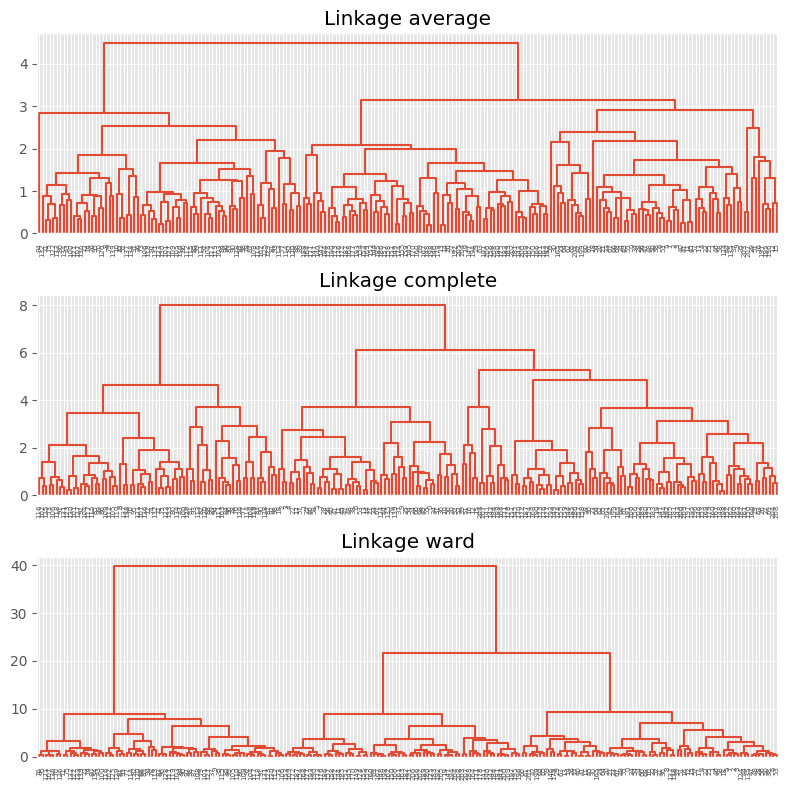

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(8, 8))
plot_dendrogram(modelo_hclust_average, labels=X_scaled.index, color_threshold=0, ax=axs[0])
axs[0].set_title("Linkage average")
plot_dendrogram(modelo_hclust_complete, labels=X_scaled.index, color_threshold=0, ax=axs[1])
axs[1].set_title("Linkage complete")
plot_dendrogram(modelo_hclust_ward, labels=X_scaled.index, color_threshold=0, ax=axs[2])
axs[2].set_title("Linkage ward")
plt.tight_layout();

Para la selección del mejor método de 'linkage' nos basaremos en cuál de los mátodos tiene un mayor salto vertical en la fusión de las ramas del dendograma. Como podemos observar en su gráfico jerárquico, el linkage "ward" es el método cuyas fusiones de clusters ocurren en puntos muy distantes. Además, este método ha realizado un buen trabajo tanto en la fusión de los datos en 2 clusters como en 3. Por ello, al igual que hemos realizado en el KMeans, vamos a comprobar el mejor número de clusters con el método Silhouette.

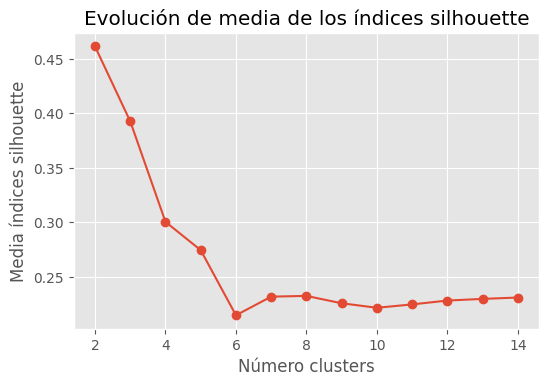

In [17]:
# Método silhouette para identificar el número óptimo de clusters
# ==============================================================================
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Evolución de media de los índices silhouette")
ax.set_xlabel('Número clusters')
ax.set_ylabel('Media índices silhouette');

Gracias a este método, al igual que en KMeans, obtenemos que el mejor valor de número de clusters es 2, pero su valor para número de clusters 3 tampoco es malo, por lo que al igual que en KMeans, seleccionaremos este número de clusters. A su vez podemos observar que el valor para n_clusters "3" se asemeja al resultado obtenido si realizamos un corte en la altura cuyo valor de distance_threshold es "10".

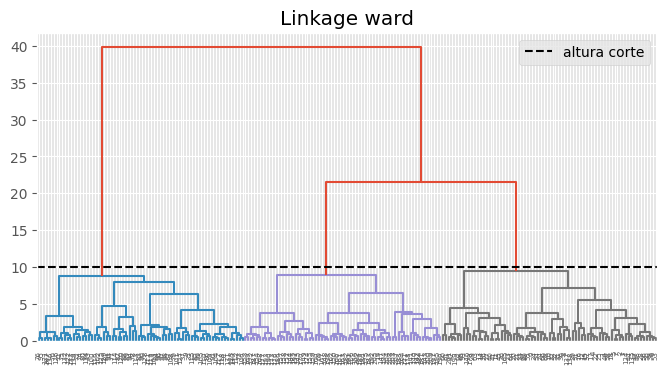

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 10
plot_dendrogram(modelo_hclust_ward, labels=X_scaled.index, color_threshold=altura_corte, ax=ax)
ax.set_title("Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

Dado que tenemos que escoger entre poner un valor al hiperparámetro distance_threshold o n_clusters, escogeremos definir el número de clusters en "3", ya que es una medida más precisa que el corte que produzca distance_threshold.

In [19]:
modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = None,
    n_clusters         = 3
)
modelo_hclust_ward.fit(X=X_scaled)

y_predict_hclust_ward = modelo_hclust_ward.fit_predict(X=X_scaled)

Ahora realizaremos el modelo DBSCAN. Este método de clustering consiste en la agrupación de puntos cercanos unos de otros, considerando los puntos aislados no agrupados como ruido.

In [20]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=2))
])

X_scaled = pipe.fit_transform(X)

Aquí tenemos como muestra el grueso de los datos sin agrupar, simplemente escalados y con un PCA para su visualización en 2D.

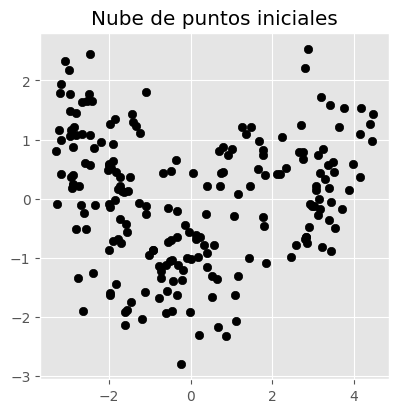

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = 'black',
    marker    = 'o',
    edgecolor = 'black'
)
#ax.legend()
ax.set_title('Nube de puntos iniciales');

Para este método de clustering, están los siguientes hiperparámetros:

* Metric: Métrica empleada como distancia. Este hiperparámetro no será modificado, porque por defecto la métrica empleada es la euclídea.
* Eps: Epsilon, distancia máxima entre dos puntos para que uno se pueda considerar vecino del otro y para que ambos se encuentren en el mismo grupo.
* Min_samples: Número mínimo de vecinos que un punto debe tener para poderse considerar núcleo.

In [86]:
modelo_dbscan = DBSCAN(
    eps          = 0.5,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_scaled)

DBSCAN()

Para este método, en vez de emplear alguna forma de comprobación gráfica del correcto funcionamiento de los hiperparámetros "eps" y "min_samples", se ha ido iterando con diferentes valores el conjunto de estos hiperparámetros que ofrecía un agrupamiento acorde a los datos del dataset y un menor número de puntos aislados o "outliers".

El min_samples será "5". Un número menor provoca la creación de clusters pequeños, superfluos, y se generan otros excesivamente grandes, creando una mala agrupación de los datos. Un número mayor genera clusters mejor definidos, pero identifica muchas instancias como outliers.

El eps será "0.5". Una cifra inferior encapsularía los datos en los mismos núcleos pero generaría un gran número de outliers. Una superior reduciría los outliers, pero encapsularía el grueso de los datos en un único cluster.

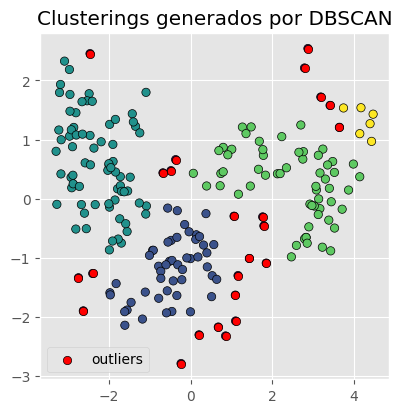

In [87]:
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x = X_scaled[:, 0],
    y = X_scaled[:, 1],
    c = labels,
    marker    = 'o',
    edgecolor = 'black'
)

# Los outliers se identifican con el label -1
ax.scatter(
    x = X_scaled[labels == -1, 0],
    y = X_scaled[labels == -1, 1],
    c = 'red',
    marker    = 'o',
    edgecolor = 'black',
    label = 'outliers'
)

ax.legend()
ax.set_title('Clusterings generados por DBSCAN');

In [88]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 4
Número de outliers encontrados: 24


La generación de 4 clusters y 24 outliers es el mejor valor que hemos podido obtener.

In [25]:
modelo_dbscan = DBSCAN(
    eps          = 0.5,
    min_samples  = 5,
    metric       = 'euclidean',
)

modelo_dbscan.fit(X=X_scaled)

y_predict_dbscan = modelo_dbscan.fit_predict(X=X_scaled)

Una vez tenidos los modelos con mejores hiperparámetros para cada método, crearemos predicciones distintivas de cada modelo para comparar entre sí el desempeño final de estos.

#Comparación Mejor Método

Ahora, con el uso de boxplots, vamos a comparar los diferentes métodos empleados con sus respectivos mejores hiperparámetros para decidir cuál desempeña un mejor rendimiento en la clusterización de los datos del dataset. Para ello, vamos a emplear la comparativa entre la encapsulación en clusters en base a la variable 'clase' y los valores de la variable 'surco' de cada instancia del dataset.

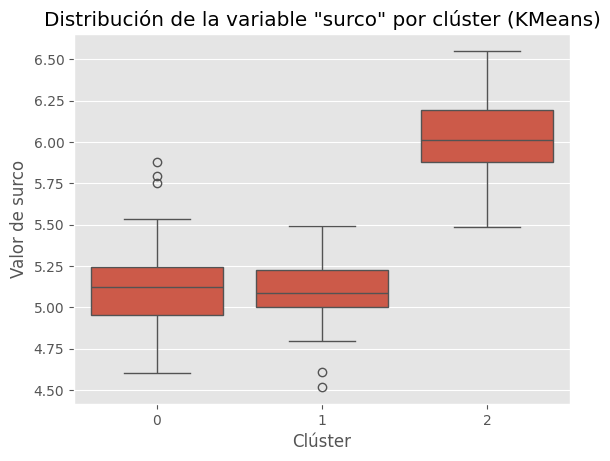

In [ ]:
df_resultados = pd.DataFrame({
    'Cluster': y_predict_kmeans,
    'Surco': X['surco'].values
})

# Boxplot: cómo varía 'surco' según el clúster
sns.boxplot(x='Cluster', y='Surco', data=df_resultados)
plt.title('Distribución de la variable "surco" por clúster (KMeans)')
plt.xlabel('Clúster')
plt.ylabel('Valor de surco')
plt.show()

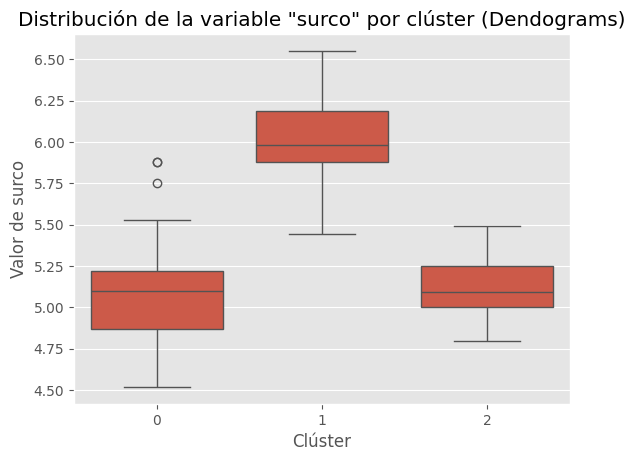

In [13]:
df_resultados = pd.DataFrame({
    'Cluster': y_predict_hclust_ward,
    'Surco': X['surco'].values
})

# Boxplot: cómo varía 'surco' según el clúster
sns.boxplot(x='Cluster', y='Surco', data=df_resultados)
plt.title('Distribución de la variable "surco" por clúster (Dendograms)')
plt.xlabel('Clúster')
plt.ylabel('Valor de surco')
plt.show()

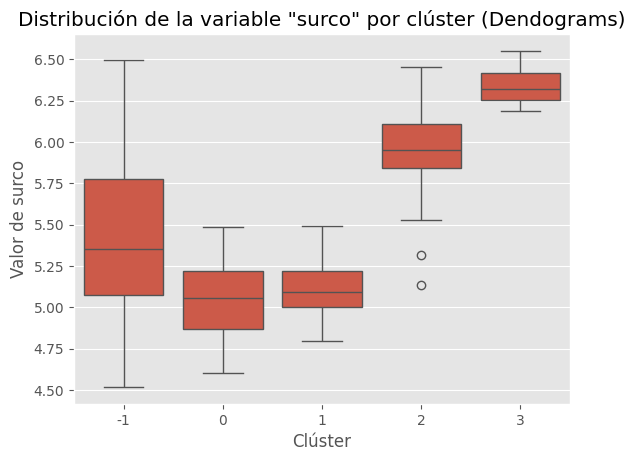

In [ ]:
df_resultados = pd.DataFrame({
    'Cluster': y_predict_dbscan,
    'Surco': X['surco'].values
})

# Boxplot: cómo varía 'surco' según el clúster
sns.boxplot(x='Cluster', y='Surco', data=df_resultados)
plt.title('Distribución de la variable "surco" por clúster (Dendograms)')
plt.xlabel('Clúster')
plt.ylabel('Valor de surco')
plt.show()

En este último caso, ya que DBSCAN define un grupo extra llamado "outliers", el "cluster" con valor -1 representa a este grupo.

Entre los diferentes modelos de clustering podemos observar que en su mayoría la representación de la variable 'clase es correcta. En KMeans y Jerárquico, el número de clusters concuerda al número de 'clases' de la variable objetivo. En cambio, en DBSCAN ha sido añadido un cuarto cluster.

La representación de los clusters en los tres métodos es similar, ya que dos de ellos tienen valores promedio de 'surco' rondando entre los 5 y 5,25. El otro, en el caso de DBSCAN otros, se encuentran sus valores de 'surco' promedio en 6,25.

Dado que ha generado un cluster de más, probablemente innecesario, el DBSCAN es el modelo que peor captura la estructura de clusters del problema. En lo referido a la comparación entre el KMeans y el de Dendogramas, sus boxplots son similares en valor y ambos representan la información de forma coherente entre sí. Sin embargo, el método de KMeans ha generado en el boxplot más valores atípicos respecto al método Jerárquico.

Por lo comentado anteriormente, se ha llegado a la conclusión de que el mejor modelo creado en esta práctica ha sido el modelo Aglomerativo/Jerárquico